# 1.

The least square problem:

$$
\min \limits _{A_{12}, A_{21}} \; \sum \limits _{i=1}^{11} (p_i(A_{12}, A_{21}) - p_i)^2
$$

A12 and A21: [1.9584184 1.6891861]
Vapor-liquid equilibria model: tensor([28.8241, 34.6443, 36.4530, 36.8673, 36.8740, 36.7498, 36.3904, 35.3848,
        32.9478, 27.7300, 17.4732], dtype=torch.float64,
       grad_fn=<AddBackward0>)
Loss: 0.000716000944521511


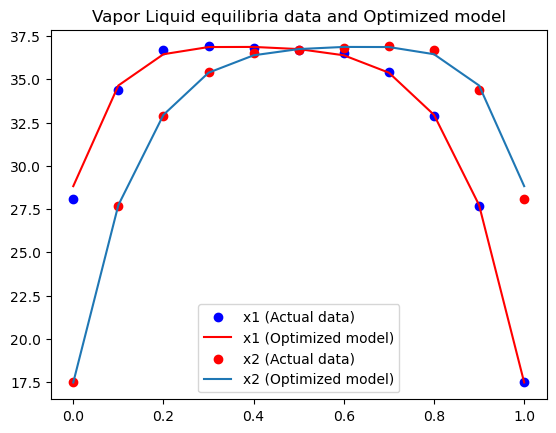

In [42]:
import torch as t
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

T = 20
a_H2o = t.tensor([8.07131, 1730.63, 233.426])
a_14_ds = t.tensor([7.43155, 1554.679, 240.337])

# The saturation pressures by using Antoine equation

water   = 10**(a_H2o[0]-(a_H2o[1]/(T+a_H2o[2])))
dioxane = 10**(a_14_ds[0]-(a_14_ds[1]/(T+a_14_ds[2])))
p_sat   = t.tensor([water,dioxane],requires_grad=False, dtype =t.float64)


# x1,x2 and p
x1 = np.asarray(np.arange(0.0,1.1,0.1))
x2 = 1-np.asarray(x1)
x  = t.tensor([x1,x2], requires_grad=False, dtype =t.float64)
p  = np.asarray([28.1, 34.4, 36.7, 36.9, 36.8, 36.7, 36.5, 35.4, 32.9, 27.7, 17.5])

# Initial values for A1 and A2
A = Variable(t.tensor([1.0,1.0]),requires_grad=True)

# Model for vapor - liquid equilibria data
def model(x,A,p_sat):
    return x[0]*t.exp((A[0]*(A[1]*x[1]/(A[0]*x[0]+A[1]*x[1]))**2))*p_sat[0]+x[1]*t.exp((A[1]*(A[0]*x[0]/(A[0]*x[0]+A[1]*x[1]))**2))*p_sat[1]

# Fix the step size
a = 0.001

# Gradient descent
for i in range(1000): 
    for i in range(0,len(x1)):
        loss = (model(x,A,p_sat)[i]-p[i])**2  # the least square problem
        loss.backward()
    A.grad.numpy()
      
    with t.no_grad():
        A -= (a * A.grad).requires_grad_(True)
        
        A.grad.zero_()

print("A12 and A21:",A.data.numpy())
print("Vapor-liquid equilibria model:",model(x,A,p_sat))
print("Loss:",loss.data.numpy())

fig, c = plt.subplots()
  
c.scatter(x1, p, c ='b', label ='x1 (Actual data)')
c.plot(x1, model(x,A,p_sat).detach().numpy(), c ='r', label ='x1 (Optimized model)')
plt.scatter(x2, p,c ='r',label ='x2 (Actual data)')
plt.plot(x2, model(x,A,p_sat).detach().numpy(),label ='x2 (Optimized model)')
plt.legend()
plt.title('Vapor Liquid equilibria data and Optimized model')
leg = c.legend
plt.show()

Yes, the model does fit well with the data since the optimization model does smoothly pass through all the points in given data.

# 2. 

In [8]:
from bayes_opt import BayesianOptimization

def fun(x1,x2):
    return -((4-(2.1*x1**2)+((x1**4)/3))*x1**2+x1*x2+(-4+(4*x2**2))*x2**2)

pbounds = {'x1': (-3, 3), 'x2': (-2, 2)}

optimizer = BayesianOptimization(f=fun,pbounds=pbounds,random_state=1)
optimizer.maximize(init_points=2,n_iter=100)
print(optimizer.max)

|   iter    |  target   |    x1     |    x2     |
-------------------------------------------------
|  1        |  0.265    | -0.4979   |  0.8813   |
|  2        | -110.1    | -2.999    | -0.7907   |
|  3        | -0.4933   | -0.3849   |  1.039    |
|  4        | -0.2833   |  1.599    | -0.5696   |
|  5        | -162.9    |  3.0      |  2.0      |
|  6        | -47.77    |  0.3665   | -2.0      |
|  7        | -150.9    |  3.0      | -2.0      |
|  8        | -0.7638   |  0.4683   | -0.02769  |
|  9        | -48.27    | -2.043    |  2.0      |
|  10       | -2.236    |  1.314    |  0.6422   |
|  11       | -50.26    |  0.5766   |  2.0      |
|  12       | -52.97    | -1.299    | -2.0      |
|  13       | -1.06     | -0.7025   | -0.5363   |
|  14       | -7.993    |  2.197    |  0.07143  |
|  15       | -48.19    | -0.8016   |  2.0      |
|  16       | -1.426    | -1.507    |  0.2863   |
|  17       | -107.6    | -3.0      |  1.181    |
|  18       | -2.305    |  1.361    | -0.01256  |


In [10]:
# Gradient descent

import numpy as np
import matplotlib.pyplot as plt

# x1,x2 values form bayesian optimization, iteration = 100
x0 = np.array([-0.0868761003138015, 0.7088699511989573])
x = np.array([0,0])

obj = lambda x: ((4-(2.1*x[0]**2)+((x[0]**4)/3))*x[0]**2+(x[0]*x[1])+(-4+(4*x[1]**2))*x[1]**2)
def grad(x):
    return np.array([8*x[0]-2.1*4*x[0]**3+2*x[0]**5+x[1], x[0]-8*x[1]+16*x[1]**3])

eps = 1e-3  # termination criterion
k = 0  # counter
soln = [x0]  
x = soln[k]  
error = np.linalg.norm(grad(x))
a = 0.01 

# Inexact line search
def line_search(x, d):
    a = 0.01 
    
    def phi(a,x,d):
        return obj(x)+a*0.8*np.dot(grad(x),d)

    while phi(a,x,d)<obj(x+a*d): 
        a = 0.5*a
        
    return a

while error >= eps: 
    d = -grad(x)
    
    a = line_search(x, d)
    
    x = x+a*d
    soln.append(x)
    error = np.linalg.norm(grad(x))
    print(grad(x))
    
soln  

[ 0.01843274 -0.04930196]
[ 0.01748632 -0.04151095]
[ 0.01653604 -0.03495795]
[ 0.01559455 -0.02944841]
[ 0.01467159 -0.02481737]
[ 0.01377446 -0.02092531]
[ 0.01290854 -0.0176544 ]
[ 0.01207757 -0.01490532]
[ 0.01128403 -0.01259446]
[ 0.01052938 -0.01065146]
[ 0.00981424 -0.00901724]
[ 0.0091386  -0.00764215]
[ 0.00850198 -0.00648452]
[ 0.00790348 -0.00550942]
[ 0.00734196 -0.00468752]
[ 0.00681605 -0.00399425]
[ 0.00632426 -0.00340899]
[ 0.005865   -0.00291446]
[ 0.00543664 -0.0024962 ]
[ 0.00503752 -0.00214205]
[ 0.00466601 -0.00184183]
[ 0.00432049 -0.00158701]
[ 0.00399937 -0.00137042]
[ 0.00370114 -0.00118607]
[ 0.00342434 -0.0010289 ]
[ 0.00316756 -0.00089469]
[ 0.00292946 -0.00077988]
[ 0.0027088  -0.00068148]
[ 0.00250436 -0.00059698]
[ 0.00231502 -0.00052427]
[ 0.00213973 -0.00046157]
[ 0.00197748 -0.00040739]
[ 0.00182734 -0.00036045]
[ 0.00168844 -0.0003197 ]
[ 0.00155997 -0.00028423]
[ 0.00144116 -0.00025328]
[ 0.00133131 -0.00022621]
[ 0.00122976 -0.00020248]
[ 0.00113589

[array([-0.0868761 ,  0.70886995]),
 array([-0.08706969,  0.70945555]),
 array([-0.08725402,  0.70994857]),
 array([-0.08742888,  0.71036368]),
 array([-0.08759424,  0.71071326]),
 array([-0.08775019,  0.71100774]),
 array([-0.0878969 ,  0.71125592]),
 array([-0.08803465,  0.71146517]),
 array([-0.08816373,  0.71164171]),
 array([-0.08828451,  0.71179077]),
 array([-0.08839735,  0.71191671]),
 array([-0.08850264,  0.71202322]),
 array([-0.08860079,  0.7121134 ]),
 array([-0.08869217,  0.71218982]),
 array([-0.08877719,  0.71225466]),
 array([-0.08885623,  0.71230976]),
 array([-0.08892965,  0.71235663]),
 array([-0.08899781,  0.71239658]),
 array([-0.08906105,  0.71243067]),
 array([-0.0891197 ,  0.71245981]),
 array([-0.08917407,  0.71248477]),
 array([-0.08922444,  0.71250619]),
 array([-0.0892711 ,  0.71252461]),
 array([-0.08931431,  0.71254048]),
 array([-0.0893543 ,  0.71255419]),
 array([-0.08939131,  0.71256605]),
 array([-0.08942555,  0.71257634]),
 array([-0.08945723,  0.7125